## Using PLUMED to intuduce CVs and analyze simulation along this CVs

In [2]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl


import matplotlib.pyplot as plt

import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.encore as encore
from MDAnalysis.analysis.rms import RMSF

from seq_tools.plot4seq import plot_prof4seq
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import seq1
from seq_tools.hist_ss import get_hist_ss_in_aln_for_shade
import numpy as np
import xvg_plot as xvg
import xpm_plot as xpm

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)


%matplotlib inline
%load_ext rpy2.ipython

from config import movtitle
from IPython.display import Markdown, display
from config import folder,descr,pname
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython



# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 150 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_DNA
Project name:  h3-h4_tm_DNA


## Let's preview

In [3]:
view_nucl('GMX_system/sys_ref.pdb', 'big_data/sys_md.xtc')


## Movie

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=1123)

### We'll start by using the distance between DNA ends as CV and analyzing it via PLUMED
- first we need to get atom indices
- init_solv_ions.pdb - is the input file for gromacs. In that file the chains were renamed.
- Since initial contents of file go first (protein and dna) we can use sys_ref.pdb, which has the origignal chain names and the same atom numbering

In [68]:
import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
sys=mda.Universe("GMX_system/sys_ref.pdb")
sys=mda.Universe("GMX_system/sys_ref.pdb",'big_data/sys_md.xtc')



#the chains have already been renamed by gromacs I=>A J=>B
#But in sys_ref they have old naming

sel_end1="(segid I and resnum -1 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum 1 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"
sel_end2="(segid I and resnum -30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6)) or (segid J and resnum 30 and (name N1 N3 N4 N6 N7 N9 C2 C4 C5 C6 C7 C8 C4 O2 O6))"

E1=sys.select_atoms(sel_end1)
E2=sys.select_atoms(sel_end2)

a=nv.show_mdanalysis(sys)
#a.add_representation('licorice',selection='all')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E1.atoms]), color='green')
a.add_representation('spacefill',selection='@'+','.join([str(i.id-1) for i in E2.atoms]), color='magenta')
a.camera = 'orthographic'
a


NGLWidget(count=1123)

In [63]:
from numpy.linalg import norm
print("Initial distance =",norm(E1.center_of_mass() - E2.center_of_mass())/10," nm\n\n")
end1at=','.join([str(i.id) for i in E1.atoms])
end2at=','.join([str(i.id) for i in E2.atoms])
chainIat=','.join([str(i.id) for i in sys.select_atoms("segid I").atoms])
chainJat=','.join([str(i.id) for i in sys.select_atoms("segid J").atoms])



#Now let's write a plumed.dat file
#NOTE: wholemolecules and NOPBC are crucial!!!

!echo "WHOLEMOLECULES ENTITY0=$chainIat ENTITY1=$chainJat" >GMX_run/plumed.dat
!echo "end1: GROUP ATOMS=$end1at" >>GMX_run/plumed.dat
!echo "end2: GROUP ATOMS=$end2at" >>GMX_run/plumed.dat
!echo "com_end1: COM ATOMS=end1" >>GMX_run/plumed.dat
!echo "com_end2: COM ATOMS=end2" >>GMX_run/plumed.dat
!echo "d1: DISTANCE ATOMS=com_end1,com_end2 NOPBC" >>GMX_run/plumed.dat
!echo "PRINT ARG=d1 FILE=colvar.dat STRIDE=10" >>GMX_run/plumed.dat
!cat GMX_run/plumed.dat

Initial distance = 7.878171640220183  nm


WHOLEMOLECULES ENTITY0=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,26

## Now we need to rerun Gromacs with PLUMED on available trjajectory

In [64]:
%%bash
cd GMX_run
gmx mdrun -ntomp 20 -rerun 7_prod.xtc -s 7_prod.tpr -plumed plumed.dat -deffnm plumed_rerun 2> 7_plumed_rerun.sterr  # if you want to run locally, nt is the number of threads
echo "Outputting gromacs error log"


Outputting gromacs error log


In [65]:
!head GMX_run/colvar.dat

#! FIELDS time d1
 0.000000 7.877746
 1000.000047 8.011638
 2000.000095 7.895487
 3000.000142 7.765974
 4000.000190 7.910652
 5000.000237 8.063817
 6000.000285 7.821266
 7000.000332 8.049810
 8000.000380 7.931090


Labels found: ['time', 'd1']


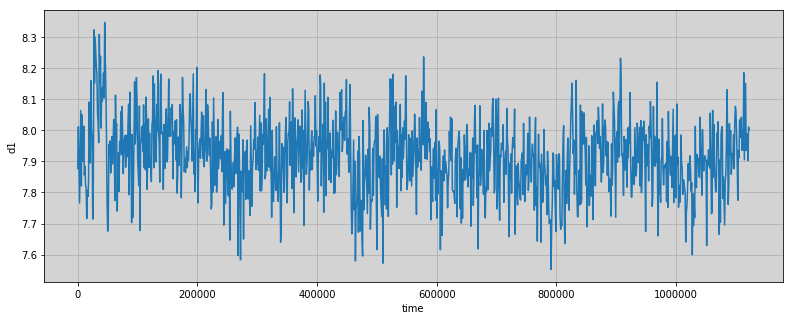

array([[0.00000000e+00, 7.87774600e+00],
       [1.00000005e+03, 8.01163800e+00],
       [2.00000010e+03, 7.89548700e+00],
       ...,
       [1.12000005e+06, 7.90273000e+00],
       [1.12100005e+06, 8.01094000e+00],
       [1.12200005e+06, 8.00187100e+00]])

In [66]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
plot_plumed('GMX_run/colvar.dat',figsize=(15,5))

[7.87817164 8.01158102 7.89574975 ... 7.90272461 8.0105491  8.0015948 ]


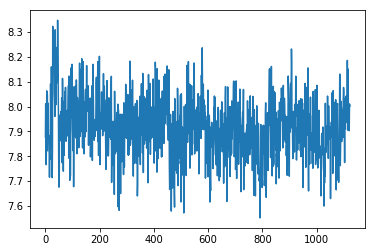

In [67]:
#Compare to MD analysis

from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sys=mda.Universe("GMX_system/sys_ref.pdb",'big_data/sys_md.xtc')
E1=sys.select_atoms(sel_end1)
E2=sys.select_atoms(sel_end2)
dist=[]
for ts in sys.trajectory:
    dist.append(norm(E1.center_of_mass() - E2.center_of_mass())/10)
dist=np.array(dist)
print(dist)
plt.plot(dist)

### Analogously DNA angle

In [71]:
import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
sys=mda.Universe("GMX_system/sys_ref.pdb")
#sys=mda.Universe("GMX_system/sys_ref.pdb",'big_data/sys_md.xtc')



#the chains have already been renamed by gromacs I=>A J=>B

sel_end1="(segid I and resnum -1) or (segid J and resnum 1)"
sel_end2="(segid I and resnum -30) or (segid J and resnum 30)"
sel_mid="(segid I and resnum -15) or (segid J and resnum 15)"

E1=sys.select_atoms(sel_end1)
E2=sys.select_atoms(sel_end2)
Em=sys.select_atoms(sel_mid)



a=nv.show_mdanalysis(sys)
#a.add_representation('licorice',selection='all')
a.add_representation('spacefill',selection='@'+','.join([str(i.id) for i in E1.atoms]), color='green')
a.add_representation('spacefill',selection='@'+','.join([str(i.id) for i in E2.atoms]), color='magenta')
a.add_representation('spacefill',selection='@'+','.join([str(i.id) for i in Em.atoms]), color='blue')


a.camera = 'orthographic'
a


NGLWidget()

In [72]:
from numpy.linalg import norm
print("Initial distance =",norm(E1.center_of_mass() - E2.center_of_mass())/10," nm\n\n")
end1at=','.join([str(i.id) for i in E1.atoms])
end2at=','.join([str(i.id) for i in E2.atoms])
midat=','.join([str(i.id) for i in Em.atoms])
chainIat=','.join([str(i.id) for i in sys.select_atoms("segid I").atoms])
chainJat=','.join([str(i.id) for i in sys.select_atoms("segid J").atoms])



#Now let's write a plumed.dat file
#NOTE: wholemolecules and NOPBC are crucial!!!

!echo "WHOLEMOLECULES ENTITY0=$chainIat ENTITY1=$chainJat" >GMX_run/plumed.dat
!echo "end1: GROUP ATOMS=$end1at" >>GMX_run/plumed.dat
!echo "end2: GROUP ATOMS=$end2at" >>GMX_run/plumed.dat
!echo "mid: GROUP ATOMS=$midat" >>GMX_run/plumed.dat
!echo "com_end1: COM ATOMS=end1" >>GMX_run/plumed.dat
!echo "com_end2: COM ATOMS=end2" >>GMX_run/plumed.dat
!echo "com_mid: COM ATOMS=mid" >>GMX_run/plumed.dat
!echo "a1: ANGLE ATOMS=com_end1,com_mid,com_end2 NOPBC" >>GMX_run/plumed.dat
!echo "PRINT ARG=a1 FILE=colvar.dat STRIDE=10" >>GMX_run/plumed.dat
!cat GMX_run/plumed.dat

Initial distance = 7.513728711238359  nm


WHOLEMOLECULES ENTITY0=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,26

## Now we need to rerun Gromacs with PLUMED on available trjajectory

In [73]:
%%bash
cd GMX_run
gmx mdrun -ntomp 20 -rerun 7_prod.xtc -s 7_prod.tpr -plumed plumed.dat -deffnm plumed_rerun 2> 7_plumed_rerun.sterr  # if you want to run locally, nt is the number of threads
echo "Outputting gromacs error log"


Outputting gromacs error log


In [74]:
!head GMX_run/colvar.dat

#! FIELDS time a1
 0.000000 2.002369
 1000.000047 2.021680
 2000.000095 2.010145
 3000.000142 1.985755
 4000.000190 2.017486
 5000.000237 2.061646
 6000.000285 2.001393
 7000.000332 2.035344
 8000.000380 1.989442


Labels found: ['time', 'a1']


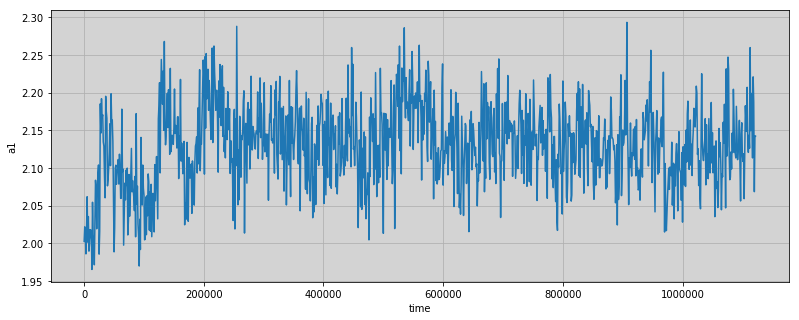

array([[0.00000000e+00, 2.00236900e+00],
       [1.00000005e+03, 2.02168000e+00],
       [2.00000010e+03, 2.01014500e+00],
       ...,
       [1.12000005e+06, 2.06834500e+00],
       [1.12100005e+06, 2.14261600e+00],
       [1.12200005e+06, 2.14208300e+00]])

In [76]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
plot_plumed('GMX_run/colvar.dat',figsize=(15,5))